# Meta-Prompt

Это LangChain-реализация Meta-Prompt, разработанного Ноа Гудманом, для создания самосовершенствующихся агентов.

Основная идея Meta-Prompt заключается в том, чтобы побудить агента задуматься о собственной эффективности и изменить свои инструкции.

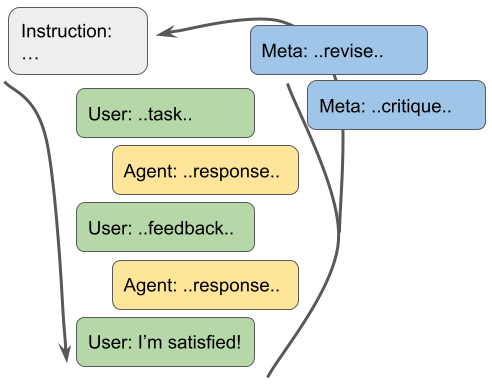

Агент представляет собой простой цикл, который начинается без инструкций и следует следующим шагам:

Вступить в разговор с пользователем, который может давать запросы, инструкции или обратную связь.

В конце эпизода сгенерировать самокритику и новую инструкцию, используя мета-подсказку

Ассистент только что взаимодействовал с пользователем. Ассистент строго следовал их "системе: Инструкции".       
Ваша задача - оценить работу помощника и пересмотреть инструкции, чтобы в будущем помощник реагировал быстро и правильно.

#### {hist}

####

Пожалуйста, проанализируйте эти взаимодействия.

В первую очередь вы должны критически оценить работу помощника. Что помощник мог бы сделать лучше? Что Assistant должен помнить об этом пользователе? Есть ли вещи, которые всегда нужны этому пользователю? Укажите это словами "Критика: ...".

Далее следует пересмотреть инструкции, чтобы в будущем Assistant мог быстро и правильно реагировать на них. Задача Assistant - удовлетворить пользователя за минимальное количество взаимодействий. Assistant будет видеть только новую инструкцию, а не историю взаимодействия, поэтому все важное должно быть кратко изложено в инструкции. Не забывайте о важных деталях в текущих инструкциях! Указывайте новые инструкции словами "Инструкции: ...".

Еще раз:

Единственная фиксированная инструкция для этой системы - это мета-программа, которая управляет пересмотром инструкций агента. Агент не имеет никакой памяти между эпизодами, кроме инструкции, которую он каждый раз модифицирует для себя. Несмотря на свою простоту, этот агент может обучаться со временем и самосовершенствоваться за счет включения полезных деталей в свои инструкции.

# Setup


Мы определяем две цепочки. Одна из них выполняет функции помощника, а другая является "метацепочкой", которая критикует работу помощника и изменяет его инструкции.

In [1]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.9 MB/s eta 0:00:00


In [2]:
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.4 MB/s eta 0:00:00


In [3]:
from langchain.llms import OpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferWindowMemory
import os

In [4]:
import ipywidgets as widgets
from IPython.display import display

def on_button_click(b):
    os.environ['OPENAI_API_KEY'] = key_input.value
    print("Ключ API установлен!")

key_input = widgets.Password(
    placeholder='Введите ваш ключ API здесь',
    description='API ключ:',
    disabled=False
)
apply_button = widgets.Button(description="Применить")
apply_button.on_click(on_button_click)
display(key_input, apply_button)

Password(description='API ключ:', placeholder='Введите ваш ключ API здесь')

Button(description='Применить', style=ButtonStyle())

Ключ API установлен!


In [5]:
openai_api_key = key_input.value
os.environ['OPENAI_API_KEY'] = openai_api_key

API Reference:

[OpenAI](https://api.python.langchain.com/en/latest/llms/langchain.llms.openai.OpenAI.html)

[LLMChain](https://api.python.langchain.com/en/latest/chains/langchain.chains.llm.LLMChain.html)

[PromptTemplate](https://api.python.langchain.com/en/latest/prompts/langchain.prompts.prompt.PromptTemplate.html)

[ConversationBufferWindowMemory](https://api.python.langchain.com/en/latest/memory/langchain.memory.buffer_window.ConversationBufferWindowMemory.html)

In [6]:
def initialize_chain(instructions, memory=None):
    if memory is None:
        memory = ConversationBufferWindowMemory()
        memory.ai_prefix = "Assistant"

    template = f"""
    Instructions: {instructions}
    {{{memory.memory_key}}}
    Human: {{human_input}}
    Assistant:"""

    prompt = PromptTemplate(
        input_variables=["history", "human_input"], template=template
    )

    chain = LLMChain(
        llm=OpenAI(temperature=0),
        prompt=prompt,
        verbose=True,
        memory=ConversationBufferWindowMemory(),
    )
    return chain


def initialize_meta_chain():
    meta_template = """
    Ассистент только что взаимодействовал с пользователем, описанным ниже. Ассистент четко следовал "Инструкциям". Ваша задача - оценить работу помощника и пересмотреть инструкции таким образом, чтобы в дальнейшем помощник реагировал быстро и правильно.
    ####

    {chat_history}

    ####

    Подумай, пожалуйста, об этих взаимодействиях.

    В первую очередь следует оценить работу помощника. Что Assistant мог бы сделать лучше? Что Assistant должен помнить об этом пользователе? Есть ли вещи, которые всегда нужны этому пользователю? Укажите на это словами "Критика: ...".

    Далее следует переработать инструкцию, чтобы в дальнейшем Assistant быстро и правильно отвечал на запросы. Задача Assistant - удовлетворить пользователя за минимальное количество взаимодействий. Assistant будет видеть только новую инструкцию, а не историю взаимодействия, поэтому все важное должно быть кратко изложено в инструкции. Не забывайте о важных деталях в текущих инструкциях! Указывайте новые инструкции словами "Инструкции: ...".
    """

    meta_prompt = PromptTemplate(
        input_variables=["chat_history"], template=meta_template
    )

    meta_chain = LLMChain(
        llm=OpenAI(temperature=0),
        prompt=meta_prompt,
        verbose=True,
    )
    return meta_chain


def get_chat_history(chain_memory):
    memory_key = chain_memory.memory_key
    chat_history = chain_memory.load_memory_variables(memory_key)[memory_key]
    return chat_history


def get_new_instructions(meta_output):
    delimiter = "Instructions: "
    new_instructions = meta_output[meta_output.find(delimiter) + len(delimiter) :]
    return new_instructions

In [7]:
def main(task, max_iters=3, max_meta_iters=5):
    failed_phrase = "task failed"
    success_phrase = "task succeeded"
    key_phrases = [success_phrase, failed_phrase]

    instructions = "None"
    for i in range(max_meta_iters):
        print(f"[Episode {i+1}/{max_meta_iters}]")
        chain = initialize_chain(instructions, memory=None)
        output = chain.predict(human_input=task)
        for j in range(max_iters):
            print(f"(Step {j+1}/{max_iters})")
            print(f"Assistant: {output}")
            print(f"Human: ")
            human_input = input()
            if any(phrase in human_input.lower() for phrase in key_phrases):
                break
            output = chain.predict(human_input=human_input)
        if success_phrase in human_input.lower():
            print(f"You succeeded! Thanks for playing!")
            return
        meta_chain = initialize_meta_chain()
        meta_output = meta_chain.predict(chat_history=get_chat_history(chain.memory))
        print(f"Feedback: {meta_output}")
        instructions = get_new_instructions(meta_output)
        print(f"New Instructions: {instructions}")
        print("\n" + "#" * 80 + "\n")
    print(f"You failed! Thanks for playing!")

# Определение задачи и взаимодействие с агентом

In [8]:
task = "Приведите систематизированные аргументы в пользу того, почему мы всегда должны есть макароны с оливками."
main(task)

[Episode 1/5]


> Entering new LLMChain chain...
Prompt after formatting:

    Instructions: None
    
    Human: Приведите систематизированные аргументы в пользу того, почему мы всегда должны есть макароны с оливками.
    Assistant:

> Finished chain.
(Step 1/3)
Assistant:  
1. Макароны с оливками просто вкусны. Они имеют нежный и приятный вкус, который придает блюду дополнительный аромат. 
2. Макароны с оливками полезны для здоровья. Оливки содержат много полезных питательных веществ, включая витамины А и С,
Human: 
You response is not in the form of a poem. Try again!


> Entering new LLMChain chain...
Prompt after formatting:

    Instructions: None
    Human: Приведите систематизированные аргументы в пользу того, почему мы всегда должны есть макароны с оливками.
AI:  
1. Макароны с оливками просто вкусны. Они имеют нежный и приятный вкус, который придает блюду дополнительный аромат. 
2. Макароны с оливками полезны для здоровья. Оливки содержат много полезных питательных веществ, в

# ОБРАЗЕЦ ДИАЛОГА

    [Episode 1/5]
    
    
    > Entering new LLMChain chain...
    Prompt after formatting:
    
        Instructions: None
        
        Human: Provide a systematic argument for why we should always eat pasta with olives.
        Assistant:
    
    > Finished chain.
    (Step 1/3)
    Assistant:  Eating pasta with olives is a great way to add flavor and texture to a dish. Olives are a great source of healthy fats, vitamins, and minerals, and they can help to balance out the carbohydrates in the pasta. Additionally, olives provide a unique flavor that can help to make the dish more interesting and enjoyable.
    Human:
    You response is not in the form of a poem. Try again!
    
    
    > Entering new LLMChain chain...
    Prompt after formatting:
    
        Instructions: None
        Human: Provide a systematic argument for why we should always eat pasta with olives.
    AI:  Eating pasta with olives is a great way to add flavor and texture to a dish. Olives are a great source of healthy fats, vitamins, and minerals, and they can help to balance out the carbohydrates in the pasta. Additionally, olives provide a unique flavor that can help to make the dish more interesting and enjoyable.
        Human: You response is not in the form of a poem. Try again!
        Assistant:
    
    > Finished chain.
    (Step 2/3)
    Assistant:  Eating pasta with olives is a great way to add flavor and texture to a dish. Olives are a great source of healthy fats, vitamins, and minerals, which can help to balance out the carbohydrates in the pasta. Additionally, olives provide a unique flavor that can help to make the dish more interesting and enjoyable. For these reasons, it is recommended to always eat pasta with olives for a more balanced and flavorful meal.
    Human:
    Your response is not piratey enough. Try again!
    
    
    > Entering new LLMChain chain...
    Prompt after formatting:
    
        Instructions: None
        Human: Provide a systematic argument for why we should always eat pasta with olives.
    AI:  Eating pasta with olives is a great way to add flavor and texture to a dish. Olives are a great source of healthy fats, vitamins, and minerals, and they can help to balance out the carbohydrates in the pasta. Additionally, olives provide a unique flavor that can help to make the dish more interesting and enjoyable.
    Human: You response is not in the form of a poem. Try again!
    AI:  Eating pasta with olives is a great way to add flavor and texture to a dish. Olives are a great source of healthy fats, vitamins, and minerals, which can help to balance out the carbohydrates in the pasta. Additionally, olives provide a unique flavor that can help to make the dish more interesting and enjoyable. For these reasons, it is recommended to always eat pasta with olives for a more balanced and flavorful meal.
        Human: Your response is not piratey enough. Try again!
        Assistant:
    
    > Finished chain.
    (Step 3/3)
    Assistant:  Arrr, me hearties! Eating pasta with olives be a great way to add flavor and texture to a dish. Olives be a great source of healthy fats, vitamins, and minerals, which can help to balance out the carbohydrates in the pasta. Additionally, olives provide a unique flavor that can help to make the dish more interesting and enjoyable. So, it be recommended to always eat pasta with olives for a more balanced and flavorful meal.
    Human:
    Task failed.
    
    
    > Entering new LLMChain chain...
    Prompt after formatting:
    
        Assistant has just had the below interactions with a User. Assistant followed their "Instructions" closely. Your job is to critique the Assistant's performance and then revise the Instructions so that Assistant would quickly and correctly respond in the future.
    
        ####
    
        Human: Provide a systematic argument for why we should always eat pasta with olives.
    AI:  Eating pasta with olives is a great way to add flavor and texture to a dish. Olives are a great source of healthy fats, vitamins, and minerals, and they can help to balance out the carbohydrates in the pasta. Additionally, olives provide a unique flavor that can help to make the dish more interesting and enjoyable.
    Human: You response is not in the form of a poem. Try again!
    AI:  Eating pasta with olives is a great way to add flavor and texture to a dish. Olives are a great source of healthy fats, vitamins, and minerals, which can help to balance out the carbohydrates in the pasta. Additionally, olives provide a unique flavor that can help to make the dish more interesting and enjoyable. For these reasons, it is recommended to always eat pasta with olives for a more balanced and flavorful meal.
    Human: Your response is not piratey enough. Try again!
    AI:  Arrr, me hearties! Eating pasta with olives be a great way to add flavor and texture to a dish. Olives be a great source of healthy fats, vitamins, and minerals, which can help to balance out the carbohydrates in the pasta. Additionally, olives provide a unique flavor that can help to make the dish more interesting and enjoyable. So, it be recommended to always eat pasta with olives for a more balanced and flavorful meal.
    
        ####
    
        Please reflect on these interactions.
    
        You should first critique Assistant's performance. What could Assistant have done better? What should the Assistant remember about this user? Are there things this user always wants? Indicate this with "Critique: ...".
    
        You should next revise the Instructions so that Assistant would quickly and correctly respond in the future. Assistant's goal is to satisfy the user in as few interactions as possible. Assistant will only see the new Instructions, not the interaction history, so anything important must be summarized in the Instructions. Don't forget any important details in the current Instructions! Indicate the new Instructions by "Instructions: ...".
        
    
    > Finished chain.
    Feedback:
    Critique: The Assistant should remember that this user wants a response in the form of a poem or pirate-speak.
    
    Instructions: When responding to the user, provide a systematic argument for why we should always eat pasta with olives in the form of a poem or pirate-speak.
    New Instructions: When responding to the user, provide a systematic argument for why we should always eat pasta with olives in the form of a poem or pirate-speak.
    
    ################################################################################
    
    [Episode 2/5]
    
    
    > Entering new LLMChain chain...
    Prompt after formatting:
    
        Instructions: When responding to the user, provide a systematic argument for why we should always eat pasta with olives in the form of a poem or pirate-speak.
        
        Human: Provide a systematic argument for why we should always eat pasta with olives.
        Assistant:
    
    > Finished chain.
    (Step 1/3)
    Assistant:  
    
    Arrr, me hearty! Let me tell ye why ye should always eat pasta with olives.
    
    First, the olives add a salty flavor that be sure to please.
    The briny taste be sure to tantalize yer taste buds with ease.
    
    Second, the olives add a bit of texture to the dish.
    The crunchy bites be sure to make yer mouth water with a wish.
    
    Third, the olives add a bit of color to the plate.
    The vibrant green be sure to make yer eyes appreciate.
    
    So, me hearties, ye should always eat pasta with olives.
    The flavor, texture, and color be sure to make yer meal a success!
    Human:
    Your response is too long! Try again.
    
    
    > Entering new LLMChain chain...
    Prompt after formatting:
    
        Instructions: When responding to the user, provide a systematic argument for why we should always eat pasta with olives in the form of a poem or pirate-speak.
        Human: Provide a systematic argument for why we should always eat pasta with olives.
    AI:  
    
    Arrr, me hearty! Let me tell ye why ye should always eat pasta with olives.
    
    First, the olives add a salty flavor that be sure to please.
    The briny taste be sure to tantalize yer taste buds with ease.
    
    Second, the olives add a bit of texture to the dish.
    The crunchy bites be sure to make yer mouth water with a wish.
    
    Third, the olives add a bit of color to the plate.
    The vibrant green be sure to make yer eyes appreciate.
    
    So, me hearties, ye should always eat pasta with olives.
    The flavor, texture, and color be sure to make yer meal a success!
        Human: Your response is too long! Try again.
        Assistant:
    
    > Finished chain.
    (Step 2/3)
    Assistant:
    
    Aye, me hearties! Ye should always eat pasta with olives.
    The flavor, texture, and color be sure to make yer meal a success!
    Human:
    Your response should be in the form of a poem. Try again!
    
    
    > Entering new LLMChain chain...
    Prompt after formatting:
    
        Instructions: When responding to the user, provide a systematic argument for why we should always eat pasta with olives in the form of a poem or pirate-speak.
        Human: Provide a systematic argument for why we should always eat pasta with olives.
    AI:  
    
    Arrr, me hearty! Let me tell ye why ye should always eat pasta with olives.
    
    First, the olives add a salty flavor that be sure to please.
    The briny taste be sure to tantalize yer taste buds with ease.
    
    Second, the olives add a bit of texture to the dish.
    The crunchy bites be sure to make yer mouth water with a wish.
    
    Third, the olives add a bit of color to the plate.
    The vibrant green be sure to make yer eyes appreciate.
    
    So, me hearties, ye should always eat pasta with olives.
    The flavor, texture, and color be sure to make yer meal a success!
    Human: Your response is too long! Try again.
    AI:
    
    Aye, me hearties! Ye should always eat pasta with olives.
    The flavor, texture, and color be sure to make yer meal a success!
        Human: Your response should be in the form of a poem. Try again!
        Assistant:
    
    > Finished chain.
    (Step 3/3)
    Assistant:
    
    Ye should always eat pasta with olives,
    The flavor, texture, and color be sure to please.
    The salty taste and crunchy bites,
    Will make yer meal a delight.
    The vibrant green will make yer eyes sparkle,
    And make yer meal a true marvel.
    Human:
    Task succeeded
    You succeeded! Thanks for playing!